# Identify buildings in images

The idea is that we can combine image locations / FOV with building footprints to deduce where the buildings are in the image, and as such to link them to other metadata such as building ID. 

We assume 'infinitely tall' buildings such that we can work in 2D only. Let's start with some panoramic images and a small segment of Amsterdam buildings.

In [75]:
# # Extract small subset
# from streetscapes.streetview import SVWorkspace
# ws = SVWorkspace("amsterdam")
# metadata = ws.load_metadata('subset_lcz_kittner_081.parquet')
# sample = metadata.cx[4.900824:4.910663, 52.369162:52.372510].query('`creator.username` == "amsterdam"')[['id', 'compass_angle', 'geometry']]
# sample.to_file('municipality.gpkg', driver='GPKG')

# buildings sample is exported from QGIS, get from Bianca.

In [76]:
import os
os.environ["PYOGRIO_USE_ARROW"] = "0"

import geopandas as gpd

buildings = gpd.read_file('/projects/0/prjs0914/streetscapes/testsample.gpkg')
photos = gpd.read_file('/projects/0/prjs0914/streetscapes/municipality.gpkg').to_crs(buildings.crs).set_index('id')

<Axes: >

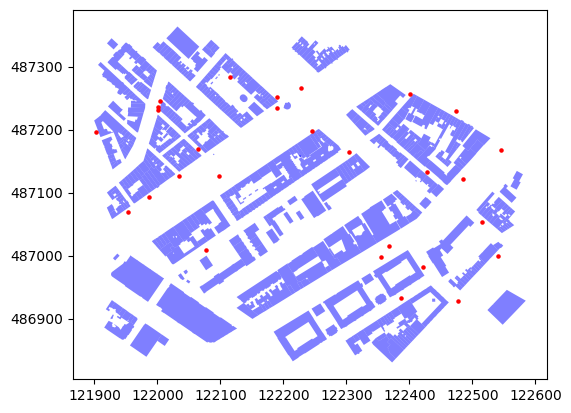

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.plot(ax=ax, color='red', markersize=5)

## Simplify geometry

we can use oriented envelope or minimum rotated rectangle

Or try to use unary_union to condense multipolygon into single polygon

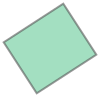

In [78]:
# Get a rectangle outline for the building
buildings.loc[538].geometry.oriented_envelope
buildings.loc[538].geometry.minimum_rotated_rectangle  # same thing

Polygon         577
MultiPolygon      3
Name: count, dtype: int64


<Axes: >

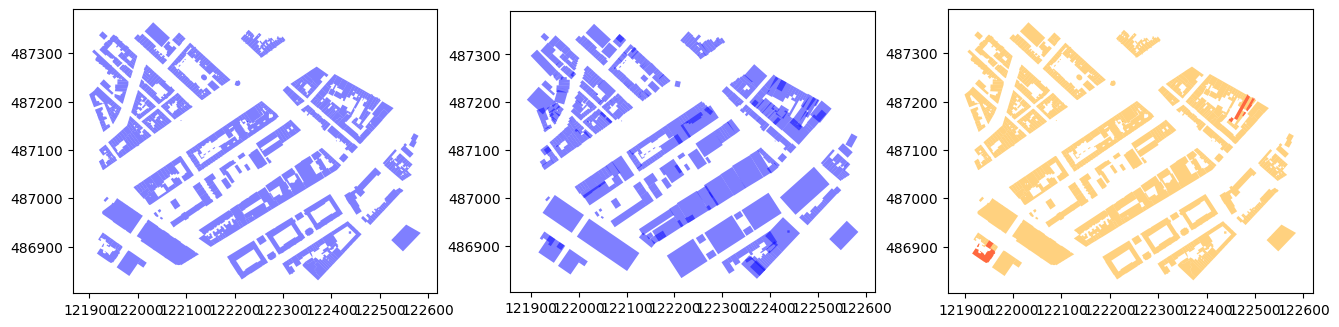

In [79]:
from shapely.ops import unary_union


fig, axs = plt.subplots(1, 3, figsize=(16, 6))

envelopes = buildings.geometry.map(lambda geom: geom.minimum_rotated_rectangle)
unioned = buildings.geometry.map(lambda geom: unary_union(geom))

# Original
buildings.plot(ax=axs[0], color='blue', alpha=0.5)

# Square envelopes
buildings.assign(geometry=envelopes).plot(ax=axs[1], color='blue', alpha=0.5)

# Simplified polygons
buildings.assign(geometry=unioned).plot(ax=axs[2], color='orange', alpha=0.5)

# Check if all multipolygons are condensed into single polygons
# Disjoint polygons can't be merged into a single polygon
print(unioned.geom_type.value_counts())
buildings.assign(geom_type = unioned.geom_type).query('geom_type == "MultiPolygon"').plot(ax=axs[2], color='red', alpha=0.5)

In [80]:
# let's continue with the simplified polygons and split the disjoint ones:
buildings = buildings.assign(geometry=unioned).explode()  # explode splits multipolygons into multiple rows with single polygons while keeping the index

## Get field of view of the images

In [81]:
# Define field of view/buffer around images

field_of_view = 80

In [82]:
def get_image_field_of_view(photos, buffer_distance=80):
    """
    Get the field of view for each photo by creating a buffer around the geometry.

    TODO: could extent this to create a wedge shape for panoramic images.
    """
    return photos.assign(geometry=photos.geometry.buffer(buffer_distance))

<Axes: >

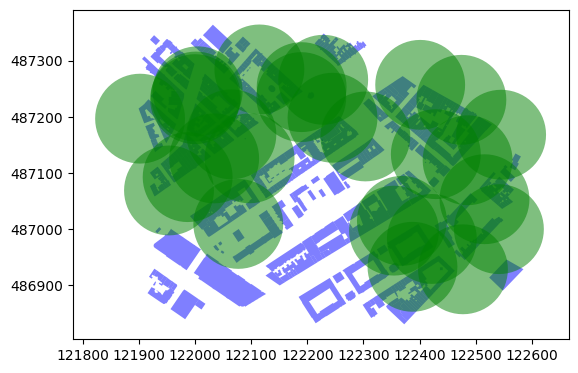

In [83]:
# Plots all photo locations with filed of view buffer

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# All buildings and photos
buildings.plot(ax=ax, color='blue', alpha=0.5)
photos.assign(geometry = photos.geometry.buffer(field_of_view)).plot(ax=ax, color='green', alpha=0.5)

# Select all buildings inside range of selected photo

In [84]:
from shapely import union_all

photo = photos.loc[['1728589477321224']]                    # select a photo id
m_photo = union_all(photo.geometry)                         # convert photo geometry to point for buffer
buffer_geom = m_photo.centroid.buffer(field_of_view)        # create buffer around photo location based on previously defined field of view
subset = buildings[buildings.intersects(buffer_geom)]       # select all buildings that intersectwith the buffer

subset.head(5)                                              # show a sample of subset

identificatie  b3_h_50p_awmean   b3_h_max   b3_h_min  \
155  NL.IMBAG.Pand.0363100012246221        19.084473  26.694761   5.866517   
156  NL.IMBAG.Pand.0363100012248781        14.221854  25.591179   4.841933   
312  NL.IMBAG.Pand.0363100012181210        14.941726  16.625959  13.376447   
321  NL.IMBAG.Pand.0363100012181207        13.936513  16.290977  12.294456   
327  NL.IMBAG.Pand.0363100012181209        14.989561  16.572344  13.266013   

     b3_h_maaiveld  b3_opp_grond  b3_volume_lod22  oorspronkelijkbouwjaar  \
155          1.015  28240.380615    508806.949219                  2017.0   
156          0.154   6915.329956     96018.890625                  2020.0   
312          0.282    105.459999      1548.282227                  1884.0   
321          0.386    132.629997      1823.533447                  1902.0   
327          0.316    107.059998      1567.934692                  1912.0   

         layer                                            path  \
155  ams_agg_1  C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg   
156  ams_agg_1  C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg   
312  ams_agg_1  C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg   
321  ams_agg_1  C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg   
327  ams_agg_1  C:/Users/admin_D0156526/Desktop/ams_agg_1.gpkg   

     real_b3_h_50p_awmean building_period  HERITAGE-class  \
155             18.069473          >=2015               9   
156             14.067854          >=2015               9   
312             14.659726       1800-1929               2   
321             13.550513       1800-1929               2   
327             14.673561       1800-1929               2   

                                              geometry  
155  POLYGON ((122278.398 486999.719, 122281.016 48...  
156  POLYGON ((122385.266 487045, 122379.258 487054...  
312  POLYGON ((122382.43 487090.625, 122380.078 487...  
321  POLYGON ((122388.953 487081.438, 122390.852 48...  
327  POLYGON ((122386.781 487086.407, 122384.625 48...

### Select buildings inside the field of view of one image

<Axes: >

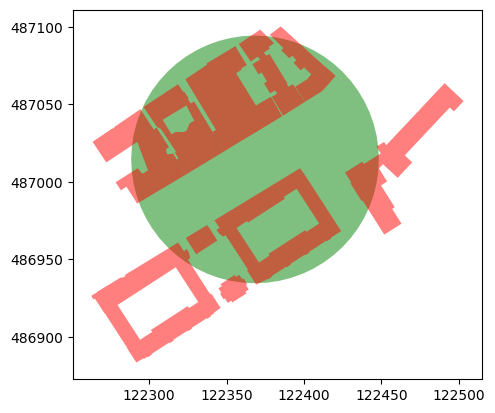

In [85]:
# Plot selected buildings within buffer of selected photo
buildings = buildings.loc[list(subset.index.values)]        # define building selection
fov = photo.geometry.buffer(field_of_view)                  # define field of view buffer

fig, ax = plt.subplots()
fov.plot(ax=ax, color='green', alpha=0.5)                   # plot field of view
subset.plot(ax=ax, color='red', alpha=0.5)                  # plot selected photos

## Try 'radial sweep' algorithm the get visibility 

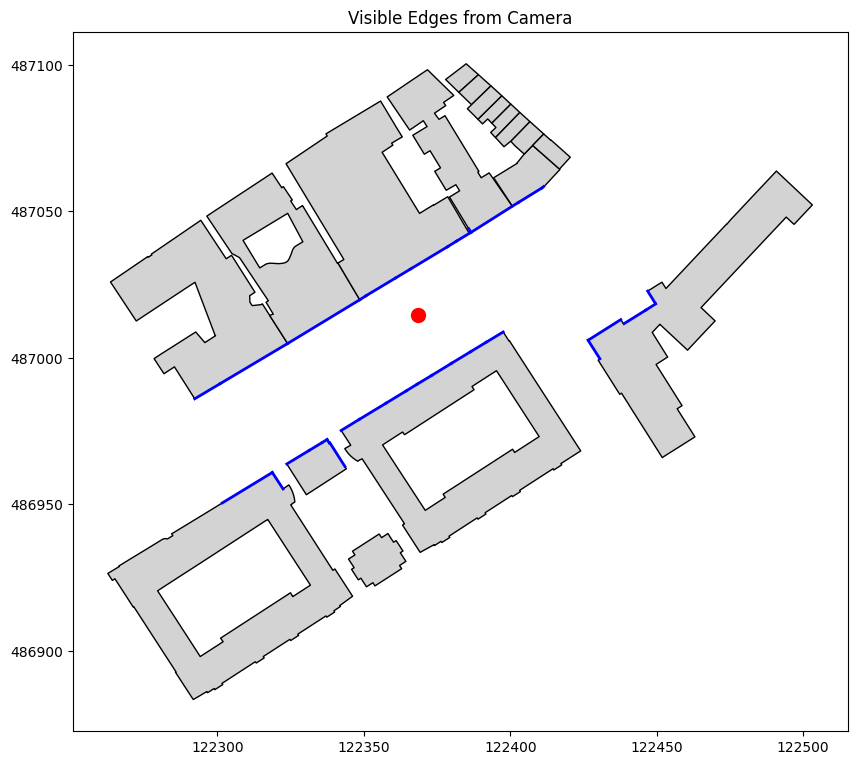

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Camera parameters
fov_center_deg = 0.0
fov_width_deg = 360.0
max_range = field_of_view

# Camera location (Shapely point)
camera_point = photo.geometry.iloc[0]

# Convert building polygons to a list of edges
edges = []
for poly in buildings.geometry:
    exterior_coords = list(poly.exterior.coords)
    n = len(exterior_coords)
    for i in range(n - 1):  # ignore closing segment because coords repeat first point
        edges.append(LineString([exterior_coords[i], exterior_coords[i+1]]))

# Function to cast a ray and find nearest intersection
def cast_ray(origin, angle_deg, edges, max_range):
    dx = np.cos(np.radians(angle_deg)) * max_range
    dy = np.sin(np.radians(angle_deg)) * max_range
    ray = LineString([origin, (origin.x + dx, origin.y + dy)])
    
    min_dist = max_range
    nearest_edge = None
    
    for edge in edges:
        inter = ray.intersection(edge)
        if not inter.is_empty:
            # Could be a Point or MultiPoint
            pts = [inter] if inter.geom_type == 'Point' else list(inter.geoms)
            for pt in pts:
                dist = origin.distance(pt)
                if dist < min_dist:
                    min_dist = dist
                    nearest_edge = edge
    return nearest_edge

# Sweep through angles and collect visible edges
angles = np.linspace(fov_center_deg - fov_width_deg/2,
                     fov_center_deg + fov_width_deg/2, 360)
visible_edges = set()

for angle in angles:
    edge = cast_ray(camera_point, angle, edges, max_range)
    if edge:
        visible_edges.add(edge)

# Plot
fig, ax = plt.subplots(figsize=(10,10))
buildings.plot(ax=ax, color='lightgray', edgecolor='black')

for edge in visible_edges:
    x, y = edge.xy
    ax.plot(x, y, color='blue', linewidth=2)

photo.plot(ax=ax, color='red', marker='o', markersize=100)
ax.set_title("Visible Edges from Camera")
plt.show()


Notice that this doesn't properly account for occlusion: the full edge is highlighted if even a small segment of it is 'hit' by a ray. The version below does a better job:

/scratch-local/70004/ipykernel_1490702/579139466.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cam = Point(photo.geometry.x[0], photo.geometry.y[0])
/scratch-local/70004/ipykernel_1490702/579139466.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


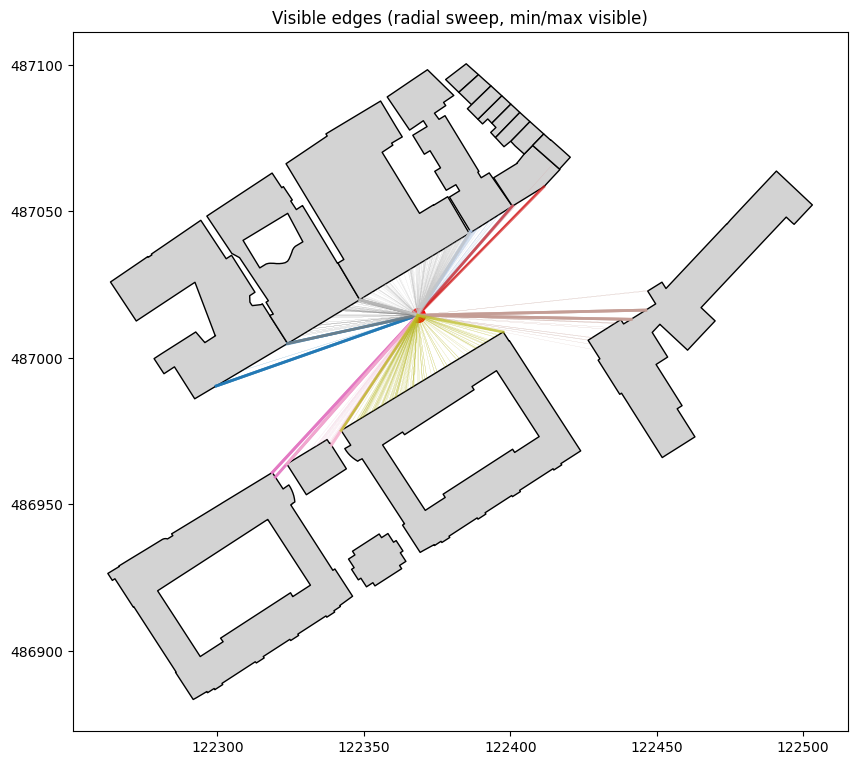

    building_idx                   identificatie  min_angle_deg  max_angle_deg
0              0  NL.IMBAG.Pand.0363100012246221     192.245671     199.337959
1              1  NL.IMBAG.Pand.0363100012248781      49.078477      57.819200
6              6  NL.IMBAG.Pand.0363100012170564      45.522110      49.078476
11            11  NL.IMBAG.Pand.0363100012165618       1.297828     358.914508
12            12  NL.IMBAG.Pand.0363100012185504     227.228162     228.636448
13            13  NL.IMBAG.Pand.0363100012182649     228.636448     236.377149
14            14  NL.IMBAG.Pand.0363100012165617     165.023698     192.245670
15            15  NL.IMBAG.Pand.0363100012170566      57.819200     165.023698
16            16  NL.IMBAG.Pand.0363100012170563     236.377149     348.932786


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba
import pandas as pd
import numpy as np

cam = Point(photo.geometry.x[0], photo.geometry.y[0])
max_range = field_of_view

# Prepare building edges
edges = []
building_polygons = list(buildings.geometry)
edge_to_building = []
for b_idx, poly in enumerate(building_polygons):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        seg = LineString([coords[i], coords[i+1]])
        edges.append(seg)
        edge_to_building.append(b_idx)

# Collect all vertices for angle candidates
vertices = [pt for seg in edges for pt in seg.coords]
angles = np.arctan2(
    np.array([y - cam.y for x, y in vertices]),
    np.array([x - cam.x for x, y in vertices])
)
angles = np.unique(np.concatenate([angles - 1e-8, angles, angles + 1e-8]))
angles = np.mod(angles, 2*np.pi)  # normalize to 0..2pi

def ray_line_intersect(p0, p1, ray_origin, ray_dir):
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = ray_origin
    dx, dy = ray_dir
    det = (x2 - x1)*(-dy) - (y2 - y1)*(-dx)
    if abs(det) < 1e-8:
        return None
    t = ((x3 - x1)*(-dy) - (y3 - y1)*(-dx))/det
    u = -((x2 - x1)*(y1 - y3) - (y2 - y1)*(x1 - x3))/det
    if 0 <= t <= 1 and u >= 0:
        return (x1 + t*(x2 - x1), y1 + t*(y2 - y1))
    return None

# Prepare data structure: store rays + min/max angle per building
building_data = {}
for b_idx in range(len(building_polygons)):
    building_data[b_idx] = {"rays": [], "min_angle": None, "max_angle": None}

# Sweep through angles and find nearest hit per angle
for angle in angles:
    ray_dir = (np.cos(angle), np.sin(angle))
    min_dist2 = max_range**2
    nearest_pt = None
    nearest_building = None

    for edge, b_idx in zip(edges, edge_to_building):
        pt = ray_line_intersect(edge.coords[0], edge.coords[1], (cam.x, cam.y), ray_dir)
        if pt:
            dx = pt[0] - cam.x
            dy = pt[1] - cam.y
            dist2 = dx*dx + dy*dy
            if dist2 < min_dist2:
                min_dist2 = dist2
                nearest_pt = pt
                nearest_building = b_idx

    if nearest_building is not None:
        data = building_data[nearest_building]
        data["rays"].append((angle, nearest_pt))
        # Update min/max visible angle
        if (data["min_angle"] is None) or (angle < data["min_angle"]):
            data["min_angle"] = angle
        if (data["max_angle"] is None) or (angle > data["max_angle"]):
            data["max_angle"] = angle

# Plot with min/max highlighted
fig, ax = plt.subplots(figsize=(10,10))
buildings.plot(ax=ax, color='lightgray', edgecolor='black')

cmap = get_cmap("tab20")
for b_idx, data in building_data.items():
    if not data["rays"]:
        continue
    color = to_rgba(cmap(b_idx % 20), alpha=0.7)
    
    # all rays lightly
    for a, pt in data["rays"]:
        ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=0.05)
    
    # highlight min/max rays
    for a, pt in data["rays"]:
        if np.isclose(a, data["min_angle"]) or np.isclose(a, data["max_angle"]):
            ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=2)

photo.plot(ax=ax, color='red', marker='o', markersize=100)
ax.set_title("Visible edges (radial sweep, min/max visible)")
plt.show()

# Build a quick table
angle_table = []
for b_idx, data in building_data.items():
    angle_table.append({
        "building_idx": b_idx,
        "identificatie": buildings.iloc[b_idx]['identificatie'],
        "min_angle_deg": np.degrees(data["min_angle"]) if data["min_angle"] is not None else None,
        "max_angle_deg": np.degrees(data["max_angle"]) if data["max_angle"] is not None else None
    })

angle_df = pd.DataFrame(angle_table)
angle_df = angle_df.dropna()
print(angle_df)


## Now let's see if these angles make sense

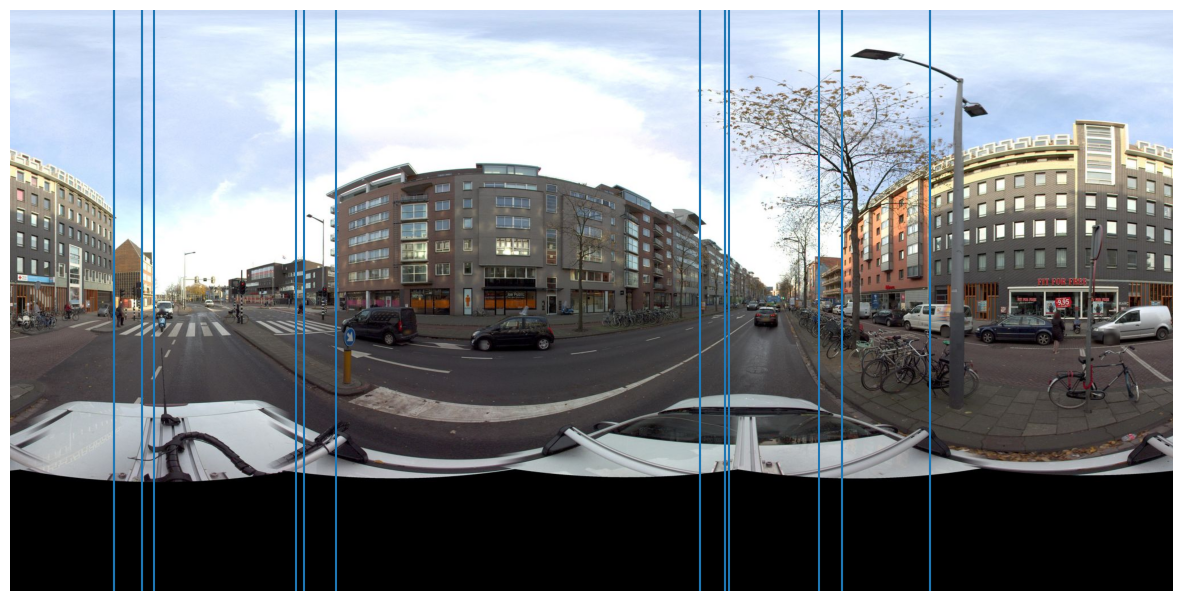

In [88]:
from PIL import Image
from streetscapes.streetview.workspace import get_image_dir
imdir = get_image_dir('mapillary')
image = Image.open(imdir / f"{photo.index[0]}.jpeg")

image_array = np.array(image)
image_array.shape

# We want 0 degrees to be the first pixel, currently 'compass_angle = 0' means
# it is exactly in the middle, so roll it back.
image_rolled = np.roll(image_array, -1024, axis=1)


def angle_to_pixel(angle, image_width=2048):
    return int(image_width / 360 * angle)

def compass_angle(angle_deg):
    compass_deg = (90 - angle_deg) % 360
    return compass_deg

fig, ax =  plt.subplots(figsize=(15, 15))
ax.imshow(image_rolled)
plt.axis('off')

for i, building in angle_df.iterrows():
    plt.axvline(angle_to_pixel(compass_angle(building.min_angle_deg)))
    plt.axvline(angle_to_pixel(compass_angle(building.max_angle_deg)))

(np.float64(-0.5), np.float64(640.5), np.float64(1023.5), np.float64(-0.5))

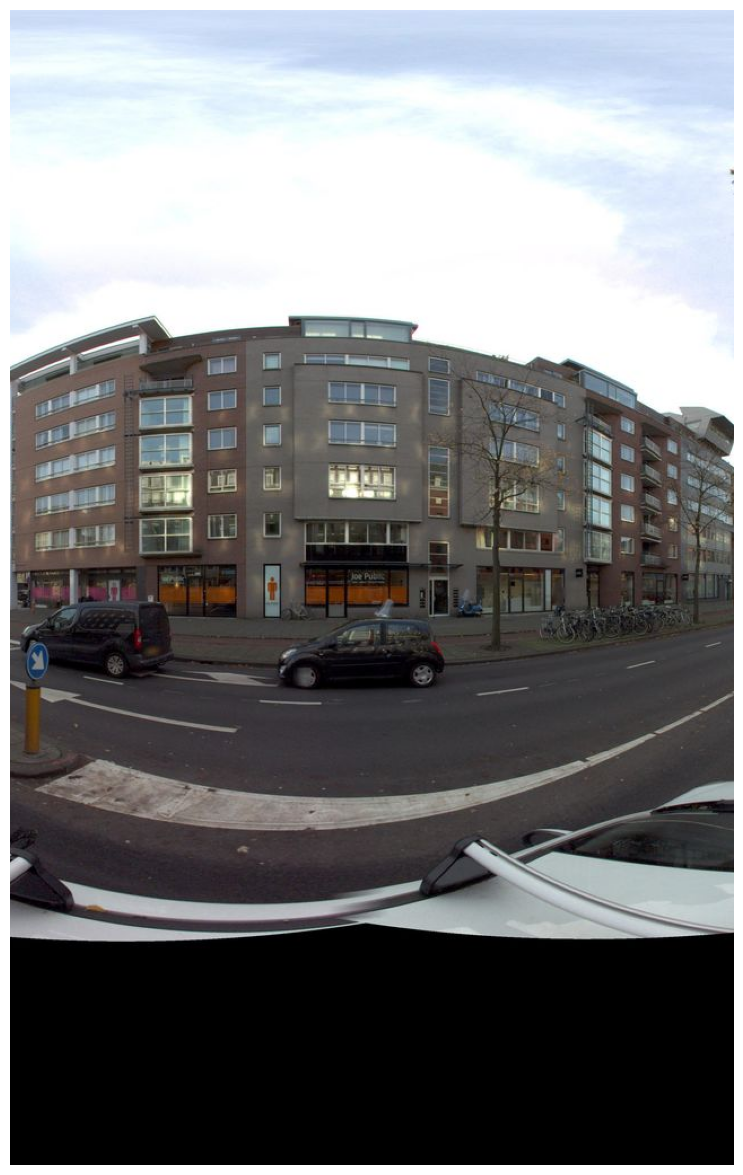

In [89]:
# Test view one cropped image

w, h = image.size

min_pixel = angle_to_pixel(compass_angle(building.min_angle_deg))
max_pixel = angle_to_pixel(compass_angle(building.max_angle_deg))


image = Image.open(imdir / f"{photo.index[0]}.jpeg")

image_rolled = np.roll(image_array, -1024, axis=1)

image_cropped = image_rolled[:, max_pixel:min_pixel,:]

fig, ax =  plt.subplots(figsize=(15, 15))
ax.imshow(image_cropped)
plt.axis('off')

# New code from "zero-wrapping" branch

## 'Radial sweep':

/scratch-local/70004/ipykernel_1490702/2311083173.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cam = Point(photo.geometry.x[0], photo.geometry.y[0])


/scratch-local/70004/ipykernel_1490702/2311083173.py:122: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


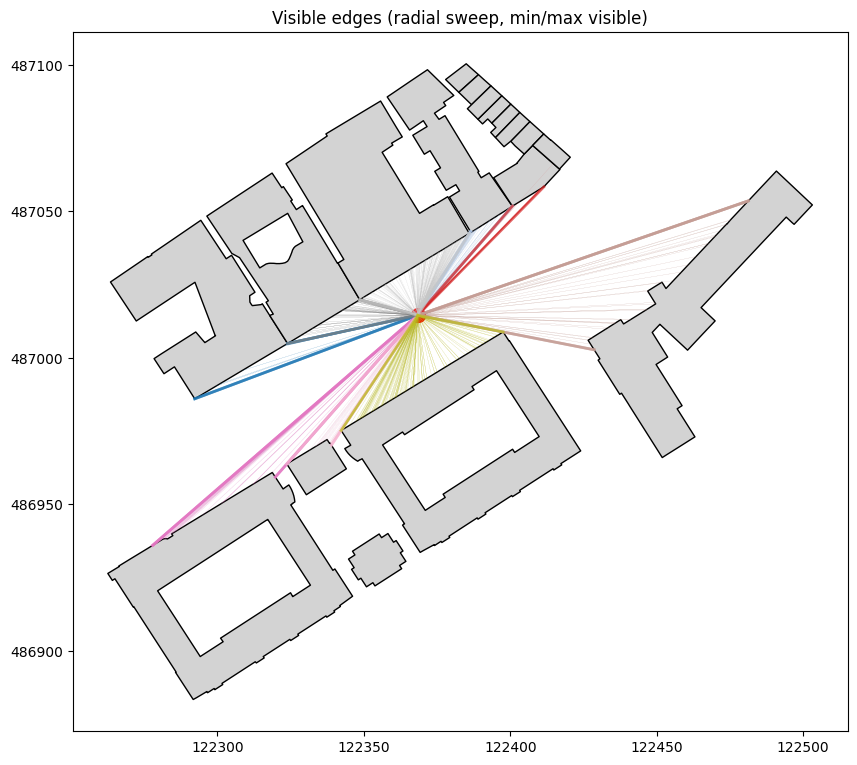

    building_idx                   identificatie  min_angle_deg  \
0              0  NL.IMBAG.Pand.0363100012246221     192.245671   
1              1  NL.IMBAG.Pand.0363100012248781      49.078477   
2              2  NL.IMBAG.Pand.0363100012181210            NaN   
3              3  NL.IMBAG.Pand.0363100012181207            NaN   
4              4  NL.IMBAG.Pand.0363100012181209            NaN   
5              5  NL.IMBAG.Pand.0363100012181206            NaN   
6              6  NL.IMBAG.Pand.0363100012170564      45.522110   
7              7  NL.IMBAG.Pand.0363100012181204            NaN   
8              8  NL.IMBAG.Pand.0363100012181203            NaN   
9              9  NL.IMBAG.Pand.0363100012181200            NaN   
10            10  NL.IMBAG.Pand.0363100012181208            NaN   
11            11  NL.IMBAG.Pand.0363100012165618     348.932786   
12            12  NL.IMBAG.Pand.0363100012185504     220.961305   
13            13  NL.IMBAG.Pand.0363100012182649     228.63644

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba
import pandas as pd


# --- Geometry prep helpers ---

def prepare_building_edges(buildings):
    """Extract edges from building polygons and track which building they belong to."""
    edges, edge_to_building = [], []
    building_polygons = list(buildings.geometry)
    for b_idx, poly in enumerate(building_polygons):
        coords = list(poly.exterior.coords)
        for i in range(len(coords) - 1):
            seg = LineString([coords[i], coords[i+1]])
            edges.append(seg)
            edge_to_building.append(b_idx)
    return edges, edge_to_building, building_polygons


def compute_candidate_angles(edges, cam):
    """Collect all vertex angles relative to camera and return sorted unique angles (normalized 0..2π)."""
    vertices = [pt for seg in edges for pt in seg.coords]
    angles = np.arctan2(
        np.array([y - cam.y for x, y in vertices]),
        np.array([x - cam.x for x, y in vertices])
    )
    angles = np.unique(np.concatenate([angles - 1e-8, angles, angles + 1e-8]))
    return np.mod(angles, 2 * np.pi)


def ray_line_intersect(p0, p1, ray_origin, ray_dir):
    """Return intersection of ray and segment if it exists, otherwise None."""
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = ray_origin
    dx, dy = ray_dir
    det = (x2 - x1)*(-dy) - (y2 - y1)*(-dx)
    if abs(det) < 1e-8:
        return None
    t = ((x3 - x1)*(-dy) - (y3 - y1)*(-dx))/det
    u = -((x2 - x1)*(y1 - y3) - (y2 - y1)*(x1 - x3))/det
    if 0 <= t <= 1 and u >= 0:
        return (x1 + t*(x2 - x1), y1 + t*(y2 - y1))
    return None


# --- Visibility computation ---

def initialize_building_data(num_buildings):
    """Initialize storage dict for rays and min/max angles per building."""
    return {b_idx: {"rays": [], "min_angle": None, "max_angle": None}
            for b_idx in range(num_buildings)}

def sweep_rays(angles, edges, edge_to_building, cam, max_range=80, fov=360):
    """Sweep through angles and find nearest hit per angle.
       Handles wrap-around properly for panoramic FOVs.
    """
    building_data = {
        b_idx: {"rays": [], "min_angle": None, "max_angle": None, "ref_angle": None, "nearest_dist": None}
        for b_idx in set(edge_to_building)
    }

    # Collect intersections
    for angle in angles:
        ray_dir = (np.cos(angle), np.sin(angle))
        min_dist2 = max_range**2
        nearest_pt = None
        nearest_building = None

        for edge, b_idx in zip(edges, edge_to_building):
            pt = ray_line_intersect(edge.coords[0], edge.coords[1], (cam.x, cam.y), ray_dir)
            if pt:
                dx = pt[0] - cam.x
                dy = pt[1] - cam.y
                dist2 = dx*dx + dy*dy
                if dist2 < min_dist2:
                    min_dist2 = dist2
                    nearest_pt = pt
                    nearest_building = b_idx

        if nearest_building is not None:
            data = building_data[nearest_building]
            data["rays"].append((angle, nearest_pt))
            data["nearest_dist"] = cam.distance(Point(nearest_pt))                  # added distance to nearest point

    # Compute min/max with wrap-around correction
    for b_idx, data in building_data.items():
        if not data["rays"]:
            continue

        # Choose reference angle (midpoint of rays OR centroid of building)
        ray_angles = np.array([a for a, _ in data["rays"]])
        # Use mean angle on the unit circle
        x = np.mean(np.cos(ray_angles))
        y = np.mean(np.sin(ray_angles))
        ref_angle = np.arctan2(y, x) % (2*np.pi)
        data["ref_angle"] = ref_angle

        if fov >= 180:  # panoramic case → unwrap around ref_angle
            rel_angles = (ray_angles - ref_angle + np.pi) % (2*np.pi) - np.pi
            min_rel, max_rel = rel_angles.min(), rel_angles.max()
            data["min_angle"] = (ref_angle + min_rel) % (2*np.pi)
            data["max_angle"] = (ref_angle + max_rel) % (2*np.pi)
        else:  # no wrap-around issue
            data["min_angle"] = ray_angles.min()
            data["max_angle"] = ray_angles.max()

    return building_data


# --- Visualization ---

def plot_rays(buildings, photo, cam, building_data):
    """Visualize buildings, rays, and highlight min/max rays."""
    fig, ax = plt.subplots(figsize=(10, 10))
    buildings.plot(ax=ax, color='lightgray', edgecolor='black')

    cmap = get_cmap("tab20")
    for b_idx, data in building_data.items():
        if not data["rays"]:
            continue
        color = to_rgba(cmap(b_idx % 20), alpha=0.7)
        # all rays lightly
        for a, pt in data["rays"]:
            ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=0.05)
        # highlight min/max rays
        for a, pt in data["rays"]:
            if np.isclose(a, data["min_angle"]) or np.isclose(a, data["max_angle"]):
                ax.plot([cam.x, pt[0]], [cam.y, pt[1]], color=color, linewidth=2)

    photo.plot(ax=ax, color='red', marker='o', markersize=100)
    ax.set_title("Visible edges (radial sweep, min/max visible)")
    plt.show()


# --- Results table ---

def build_angle_table(buildings, building_data):
    """Create DataFrame with min/max angle per building in degrees."""
    angle_table = []
    for b_idx, data in building_data.items():
        angle_table.append({
            "building_idx": b_idx,
            "identificatie": buildings.iloc[b_idx]['identificatie'],
            "min_angle_deg": np.degrees(data["min_angle"]) if data["min_angle"] is not None else None,
            "max_angle_deg": np.degrees(data["max_angle"]) if data["max_angle"] is not None else None,
            "nearest_dist": data["nearest_dist"]
        })
    return pd.DataFrame(angle_table)


# --- Main pipeline ---

def compute_visible_building_angles(buildings, photo, max_range=120, fov=360):
    cam = Point(photo.geometry.x[0], photo.geometry.y[0])
    edges, edge_to_building, building_polygons = prepare_building_edges(buildings)
    angles = compute_candidate_angles(edges, cam)
    building_data = initialize_building_data(len(building_polygons))
    building_data = sweep_rays(angles, edges, edge_to_building, cam, max_range, fov)
    plot_rays(buildings, photo, cam, building_data)
    angle_df = build_angle_table(buildings, building_data)
    #angle_df = angle_df.dropna()                                                            # drop rows with not visible buildings
    print(angle_df)
    return angle_df, building_data

angle_df, building_data = compute_visible_building_angles(buildings, photo, max_range=120)

In [91]:
angle_df

building_idx                   identificatie  min_angle_deg  \
0              0  NL.IMBAG.Pand.0363100012246221     192.245671   
1              1  NL.IMBAG.Pand.0363100012248781      49.078477   
2              2  NL.IMBAG.Pand.0363100012181210            NaN   
3              3  NL.IMBAG.Pand.0363100012181207            NaN   
4              4  NL.IMBAG.Pand.0363100012181209            NaN   
5              5  NL.IMBAG.Pand.0363100012181206            NaN   
6              6  NL.IMBAG.Pand.0363100012170564      45.522110   
7              7  NL.IMBAG.Pand.0363100012181204            NaN   
8              8  NL.IMBAG.Pand.0363100012181203            NaN   
9              9  NL.IMBAG.Pand.0363100012181200            NaN   
10            10  NL.IMBAG.Pand.0363100012181208            NaN   
11            11  NL.IMBAG.Pand.0363100012165618     348.932786   
12            12  NL.IMBAG.Pand.0363100012185504     220.961305   
13            13  NL.IMBAG.Pand.0363100012182649     228.636448   
14            14  NL.IMBAG.Pand.0363100012165617     165.023698   
15            15  NL.IMBAG.Pand.0363100012170566      57.819200   
16            16  NL.IMBAG.Pand.0363100012170563     236.377149   
17            17  NL.IMBAG.Pand.0363100012170562            NaN   

    max_angle_deg  nearest_dist  
0      200.531560     81.310511  
1       57.819200     33.787498  
2             NaN           NaN  
3             NaN           NaN  
4             NaN           NaN  
5             NaN           NaN  
6       49.078476     49.326690  
7             NaN           NaN  
8             NaN           NaN  
9             NaN           NaN  
10            NaN           NaN  
11      19.084437    119.417878  
12     228.636448     73.592979  
13     236.377149     53.253979  
14     192.245670     28.425344  
15     165.023698     20.489985  
16     348.932786     29.719607  
17            NaN           NaN

# Add building filter based on field of view

Filter is based on trigonometry:
- How large do the viewing angle of a building need to be in order to capture at least X m of building wall?

In [92]:
minimum_wall = 4                                              # Define a minimum amount of wall width that needs to be seen from the picture [m]

In [93]:
# Create control dataframe for filter:

df = angle_df

minimum_fov_angle = (360*minimum_wall)/(2 *np.pi*df.nearest_dist)                       # Define minimum field of view to see ≥ minimum_wall [degree]
minimum_fov_angle

# Add some checking fields:
df["minimum_fov_angle"] = minimum_fov_angle
df["negative_minimum_fov_angle"] = -(360-minimum_fov_angle)                             # negative field of view angle
df["diff_angle"] = df.max_angle_deg - df.min_angle_deg                                  # viewing angle

df["smaller than negative"] = df.max_angle_deg - df.min_angle_deg < df.negative_minimum_fov_angle
df["smaller than min"] = df.max_angle_deg - df.min_angle_deg < minimum_fov_angle

df

building_idx                   identificatie  min_angle_deg  \
0              0  NL.IMBAG.Pand.0363100012246221     192.245671   
1              1  NL.IMBAG.Pand.0363100012248781      49.078477   
2              2  NL.IMBAG.Pand.0363100012181210            NaN   
3              3  NL.IMBAG.Pand.0363100012181207            NaN   
4              4  NL.IMBAG.Pand.0363100012181209            NaN   
5              5  NL.IMBAG.Pand.0363100012181206            NaN   
6              6  NL.IMBAG.Pand.0363100012170564      45.522110   
7              7  NL.IMBAG.Pand.0363100012181204            NaN   
8              8  NL.IMBAG.Pand.0363100012181203            NaN   
9              9  NL.IMBAG.Pand.0363100012181200            NaN   
10            10  NL.IMBAG.Pand.0363100012181208            NaN   
11            11  NL.IMBAG.Pand.0363100012165618     348.932786   
12            12  NL.IMBAG.Pand.0363100012185504     220.961305   
13            13  NL.IMBAG.Pand.0363100012182649     228.636448   
14            14  NL.IMBAG.Pand.0363100012165617     165.023698   
15            15  NL.IMBAG.Pand.0363100012170566      57.819200   
16            16  NL.IMBAG.Pand.0363100012170563     236.377149   
17            17  NL.IMBAG.Pand.0363100012170562            NaN   

    max_angle_deg  nearest_dist  minimum_fov_angle  \
0      200.531560     81.310511           2.818616   
1       57.819200     33.787498           6.783075   
2             NaN           NaN                NaN   
3             NaN           NaN                NaN   
4             NaN           NaN                NaN   
5             NaN           NaN                NaN   
6       49.078476     49.326690           4.646229   
7             NaN           NaN                NaN   
8             NaN           NaN                NaN   
9             NaN           NaN                NaN   
10            NaN           NaN                NaN   
11      19.084437    119.417878           1.919169   
12     228.636448     73.592979           3.114198   
13     236.377149     53.253979           4.303587   
14     192.245670     28.425344           8.062633   
15     165.023698     20.489985          11.185129   
16     348.932786     29.719607           7.711512   
17            NaN           NaN                NaN   

    negative_minimum_fov_angle  diff_angle  smaller than negative  \
0                  -357.181384    8.285889                  False   
1                  -353.216925    8.740723                  False   
2                          NaN         NaN                  False   
3                          NaN         NaN                  False   
4                          NaN         NaN                  False   
5                          NaN         NaN                  False   
6                  -355.353771    3.556366                  False   
7                          NaN         NaN                  False   
8                          NaN         NaN                  False   
9                          NaN         NaN                  False   
10                         NaN         NaN                  False   
11                 -358.080831 -329.848350                  False   
12                 -356.885802    7.675143                  False   
13                 -355.696413    7.740701                  False   
14                 -351.937367   27.221972                  False   
15                 -348.814871  107.204497                  False   
16                 -352.288488  112.555636                  False   
17                         NaN         NaN                  False   

    smaller than min  
0              False  
1              False  
2              False  
3              False  
4              False  
5              False  
6               True  
7              False  
8              False  
9              False  
10             False  
11              True  
12             False  
13             False  
14             False  
15             False  


In [94]:
# Add filter: 

# Drop all rows where the field of view is smaller than the minimum_fov_angle (works for both positive and negative angles)

df_dropped = df.drop(df[
    ((df.max_angle_deg - df.min_angle_deg < minimum_fov_angle) & (df.max_angle_deg - df.min_angle_deg > 0)) | 
    ((df.max_angle_deg - df.min_angle_deg < -(360 - minimum_fov_angle)) & (df.max_angle_deg - df.min_angle_deg < 0))
    ].index)
    # If angle is positive drop row if viewing angle is smaller than defined minimum,
    # if angle is negative drop row if viewing angle is larger (i.e. less negative) than the "inverse angle" of the defined minimum angle. "

df_dropped.dropna()                         # drop NaN and print

building_idx                   identificatie  min_angle_deg  \
0              0  NL.IMBAG.Pand.0363100012246221     192.245671   
1              1  NL.IMBAG.Pand.0363100012248781      49.078477   
11            11  NL.IMBAG.Pand.0363100012165618     348.932786   
12            12  NL.IMBAG.Pand.0363100012185504     220.961305   
13            13  NL.IMBAG.Pand.0363100012182649     228.636448   
14            14  NL.IMBAG.Pand.0363100012165617     165.023698   
15            15  NL.IMBAG.Pand.0363100012170566      57.819200   
16            16  NL.IMBAG.Pand.0363100012170563     236.377149   

    max_angle_deg  nearest_dist  minimum_fov_angle  \
0      200.531560     81.310511           2.818616   
1       57.819200     33.787498           6.783075   
11      19.084437    119.417878           1.919169   
12     228.636448     73.592979           3.114198   
13     236.377149     53.253979           4.303587   
14     192.245670     28.425344           8.062633   
15     165.023698     20.489985          11.185129   
16     348.932786     29.719607           7.711512   

    negative_minimum_fov_angle  diff_angle  smaller than negative  \
0                  -357.181384    8.285889                  False   
1                  -353.216925    8.740723                  False   
11                 -358.080831 -329.848350                  False   
12                 -356.885802    7.675143                  False   
13                 -355.696413    7.740701                  False   
14                 -351.937367   27.221972                  False   
15                 -348.814871  107.204497                  False   
16                 -352.288488  112.555636                  False   

    smaller than min  
0              False  
1              False  
11              True  
12             False  
13             False  
14             False  
15             False  
16             False

# Visualise cutting lines on photo

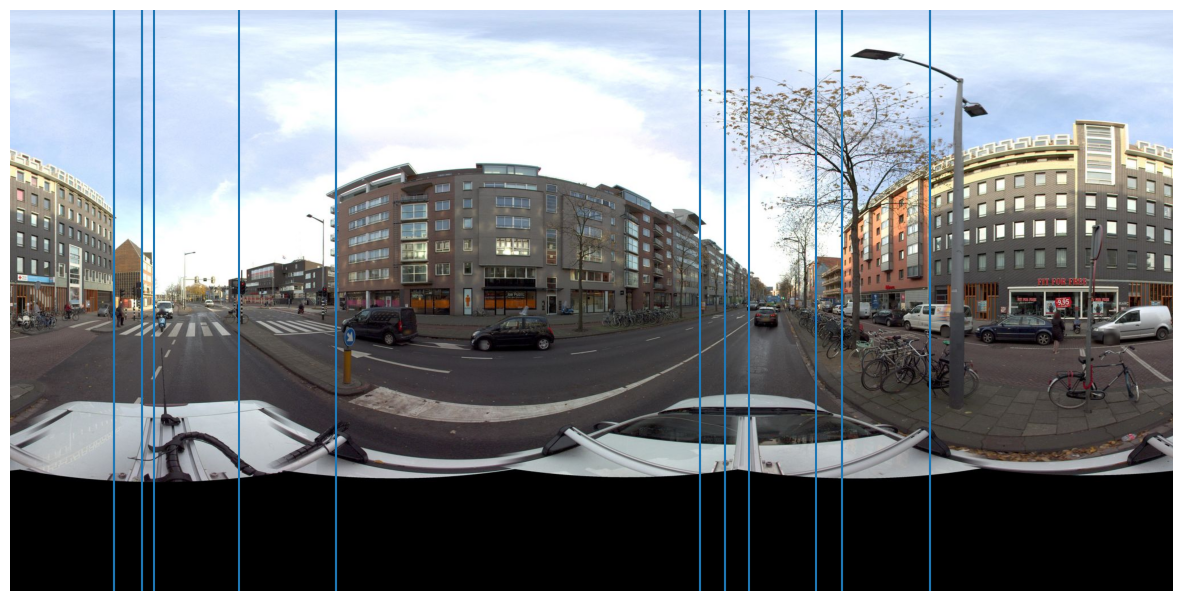

In [95]:
from PIL import Image
from streetscapes.streetview.workspace import get_image_dir
imdir = get_image_dir('mapillary')
image = Image.open(imdir / f"{photo.index[0]}.jpeg")

image_array = np.array(image)
image_array.shape

# We want 0 degrees to be the first pixel, currently 'compass_angle = 0' means
# it is exactly in the middle, so roll it back.
image_rolled = np.roll(image_array, -1024, axis=1)


def angle_to_pixel(angle, image_width=2048):
    return int(image_width / 360 * angle)

def compass_angle(angle_deg):
    compass_deg = (90 - angle_deg) % 360
    return compass_deg

fig, ax =  plt.subplots(figsize=(15, 15))
ax.imshow(image_rolled)
plt.axis('off')

for i, building in angle_df.dropna().iterrows():
    plt.axvline(angle_to_pixel(compass_angle(building.min_angle_deg)))
    plt.axvline(angle_to_pixel(compass_angle(building.max_angle_deg)))

# Plot visible angle spans of buildings with colour shade:

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import to_rgba

# --- helpers (same logic you used before) ---

def _mathdeg_to_compass_deg(angle_deg):
    # math: 0=East, CCW  →  compass: 0=North, CW
    return (90.0 - angle_deg) % 360.0

def _deg_to_pixel(deg, width):
    return int((deg % 360.0) / 360.0 * width)

def _roll_north_to_left(image_array):
    # Your panoramas have 0° (North) in the middle → roll left by W/2
    w = image_array.shape[1]
    return np.roll(image_array, -w // 2, axis=1)

def plot_building_angles_fill(image_array, angle_df, figsize=(15, 5), alpha_fill=0.3):
    """
    Show the panorama with per-building angle spans overlaid as colored bands.
    - angle_df must have columns: 'min_angle_deg', 'max_angle_deg', 'identificatie' (optional).
    - min/max are in *math degrees* (like your original np.degrees output).
    """
    rolled = _roll_north_to_left(image_array)
    w = rolled.shape[1]
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(rolled)
    ax.axis("off")

    cmap = get_cmap("tab20")

    for i, row in angle_df.iterrows():
        mind = row.get("min_angle_deg", None)
        maxd = row.get("max_angle_deg", None)
        if pd.isna(mind) or pd.isna(maxd):
            continue

        # math → compass → pixels
        dmin = _mathdeg_to_compass_deg(mind)
        dmax = _mathdeg_to_compass_deg(maxd)
        p1 = _deg_to_pixel(dmin, w)
        p2 = _deg_to_pixel(dmax, w)

        color = to_rgba(cmap(i % 20), alpha=alpha_fill)

        # Fill the *shorter arc* on the circle
        delta = (p2 - p1) % w
        if delta == 0:
            ax.axvline(p1, color=color, linewidth=2)
        elif delta <= w // 2:
            if p1 <= p2:
                ax.axvspan(p1, p2, color=color)
            else:
                ax.axvspan(p1, w, color=color)
                ax.axvspan(0, p2, color=color)
        else:
            if p2 <= p1:
                ax.axvspan(p2, p1, color=color)
            else:
                ax.axvspan(p2, w, color=color)
                ax.axvspan(0, p1, color=color)

    ax.set_title("Building angle spans (rolled: 0° compass at left)")
    plt.show()

/scratch-local/70004/ipykernel_1490702/3445680352.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20")


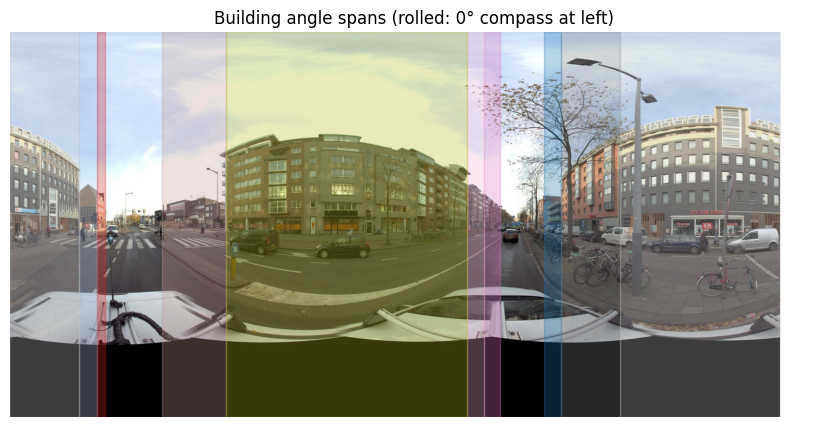

In [97]:
plot_building_angles_fill(image_array, angle_df, figsize=(15, 5), alpha_fill=0.3)

# Plot cropped building images from panorama

In [98]:
def _crop_shorter_arc(rolled, p1, p2):
    """
    Crop the *shorter* arc of columns between p1 and p2 on the rolled panorama.
    Handles wrap-around. Returns cropped image (H x Wc x C).
    """
    H, W, C = rolled.shape
    p1 %= W
    p2 %= W
    delta = (p2 - p1) % W  # width going p1 -> p2

    if delta == 0:
        return None  # degenerate (no visible span)

    if delta <= W // 2:
        # take arc p1 -> p2
        if p1 <= p2:
            return rolled[:, p1:p2, :]
        else:
            return np.hstack([rolled[:, p1:, :], rolled[:, :p2, :]])
    else:
        # take arc p2 -> p1 (the other, shorter side)
        if p2 <= p1:
            return rolled[:, p2:p1, :]
        else:
            return np.hstack([rolled[:, p2:, :], rolled[:, :p1, :]])


def plot_building_crops_variable_width(image_array, angle_df, figsize=(20, 5)):
    rolled = _roll_north_to_left(image_array)
    W = rolled.shape[1]

    crops, titles, widths = [], [], []
    for _, row in angle_df.iterrows():
        mind, maxd = row.get("min_angle_deg"), row.get("max_angle_deg")
        if pd.isna(mind) or pd.isna(maxd):
            continue
        dmin = _mathdeg_to_compass_deg(mind)
        dmax = _mathdeg_to_compass_deg(maxd)
        p1, p2 = _deg_to_pixel(dmin, W), _deg_to_pixel(dmax, W)
        crop = _crop_shorter_arc(rolled, p1, p2)
        if crop is None or crop.shape[1] == 0:
            continue
        crops.append(crop)
        titles.append(str(row.get("identificatie", row.get("building_idx"))))
        widths.append(crop.shape[1])

    if not crops:
        print("No valid building crops to show.")
        return

    # --- sort by width ---
    sorted_items = sorted(zip(widths, crops, titles), key=lambda x: x[0], reverse=True)
    widths, crops, titles = zip(*sorted_items)

    # --- layout with width ratios ---
    total_w = sum(widths)
    width_ratios = [w / total_w for w in widths]

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, len(crops), width_ratios=width_ratios)

    for i, (crop, title) in enumerate(zip(crops, titles)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(crop, aspect="auto")
        ax.set_title(title, fontsize=8)
        ax.axis("off")

    print('widths', widths)

    plt.tight_layout()
    plt.show()

widths (641, 610, 171, 155, 49, 47, 44, 43, 21)


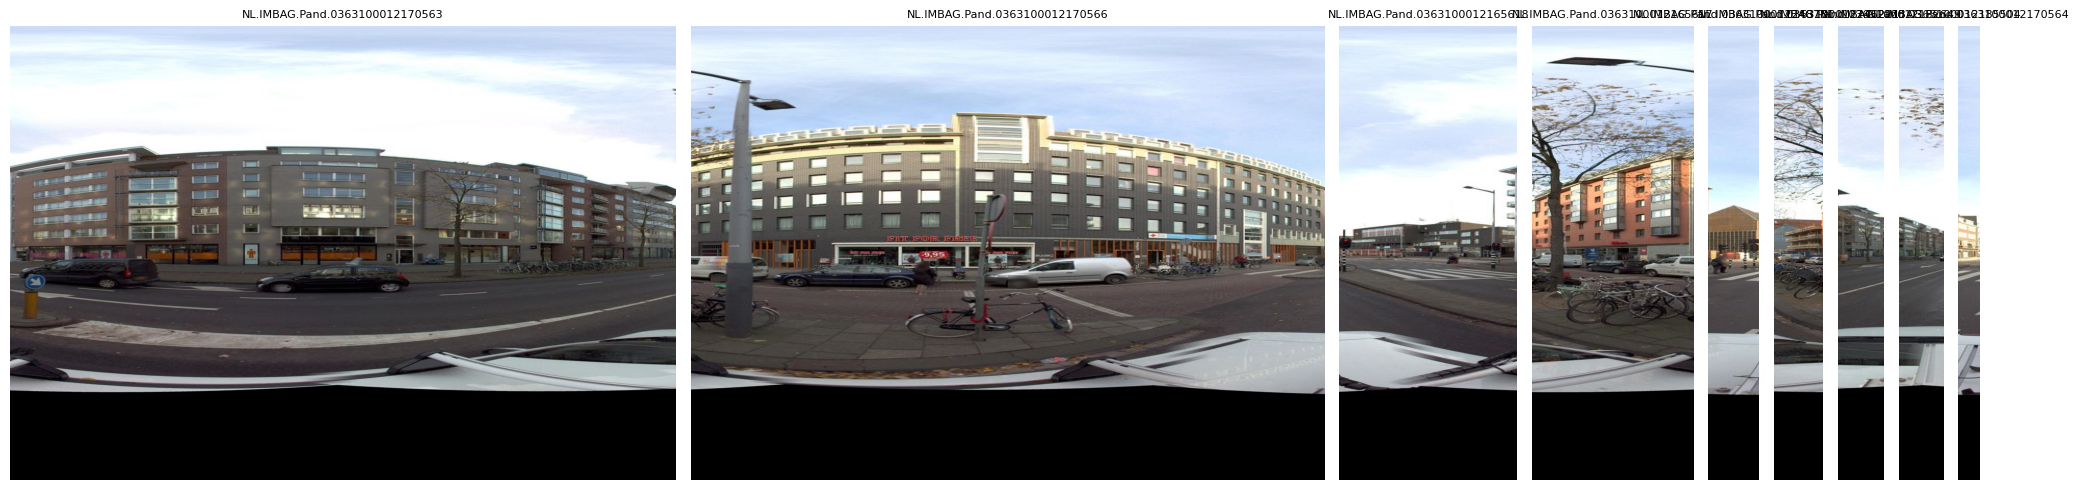

In [99]:
plot_building_crops_variable_width(image_array, angle_df)

# Visualise closest point on building to photo and calculate distance

/home/bsandvik/Urban-M4/streetscapes/.venv/lib/python3.12/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/bsandvik/Urban-M4/streetscapes/.venv/lib/python3.12/site-packages/geopandas/geoseries.py:772: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


28.425344175258306

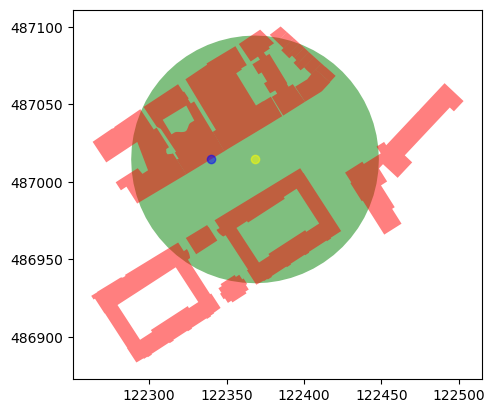

: 

In [ ]:
gdf_pt = gpd.GeoSeries([Point(nearest_pt)], crs={'init': 'epsg:28992'})                     # redifine nearest_point as geoseries for plotting purposes

# Plot:
fig, ax = plt.subplots()
fov.plot(ax=ax, color='green', alpha=0.5)                   # plot field of view
subset.plot(ax=ax, color='red', alpha=0.5)                  # plot selected buildings
photo.plot(ax=ax, color='yellow', alpha=0.5)                  # plot selected photo
gdf_pt.plot(ax=ax, color='blue', alpha=0.5)                  # plot nearest_pt

dist = gdf_pt[0].distance(photo.geometry[0])                                                # calculate distance [m] between photo and 'nearest_pt'
dist